In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import matplotlib.pyplot as plt
import os
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
#file_path = '期货.xlsx'

#清洗数据
#前两行
#df_header = pd.read_excel(file_path, header=None, nrows=2)

#合并前两行
#new_columns = []
#for col1, col2 in zip(df_header.iloc[0], df_header.iloc[1]):
    #处理空值
    #col1_str = str(col1).strip() if pd.notna(col1) else ''
    #col2_str = str(col2).strip() if pd.notna(col2) else ''
    #new_col = f"{col1_str}_{col2_str}".strip('_')
    #new_columns.append(new_col)

#从第3行开始读数据
#df = pd.read_excel(file_path, header=[2])
#df.columns = new_columns  #替换合成列名


In [3]:
#保留“日期”
#date_cols = [col for col in df.columns if '日期' in str(col)]

#保留“收盘价”
#close_cols = [col for col in df.columns if str(col).strip().endswith('_收盘价')]

# 最终保留的列
#keep_cols = date_cols + close_cols
#df_filtered = df[keep_cols].copy()

# 保存结果
#df_filtered.to_excel("期货收盘价.xlsx", index=False)

In [4]:
OBS_VAR = 0.01
STATE_VAR = 0.0001
INIT_MEAN = 1.0
INIT_VAR = 1.0
WIN = 10
OPEN_H = 2.0
OPEN_L = -2.0
CLOSE_H = 0.5
CLOSE_L = -0.5
STOP_SPREAD = 3.0
MAX_HOLD = 10

In [5]:
df = pd.read_excel("期货收盘价.xlsx")
df['datetime'] = pd.to_datetime(df['日期'])
df = df[['datetime',"铁矿石主连_收盘价","焦炭主连_收盘价"]]
df = df.sort_values("datetime").reset_index(drop=True)

In [6]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


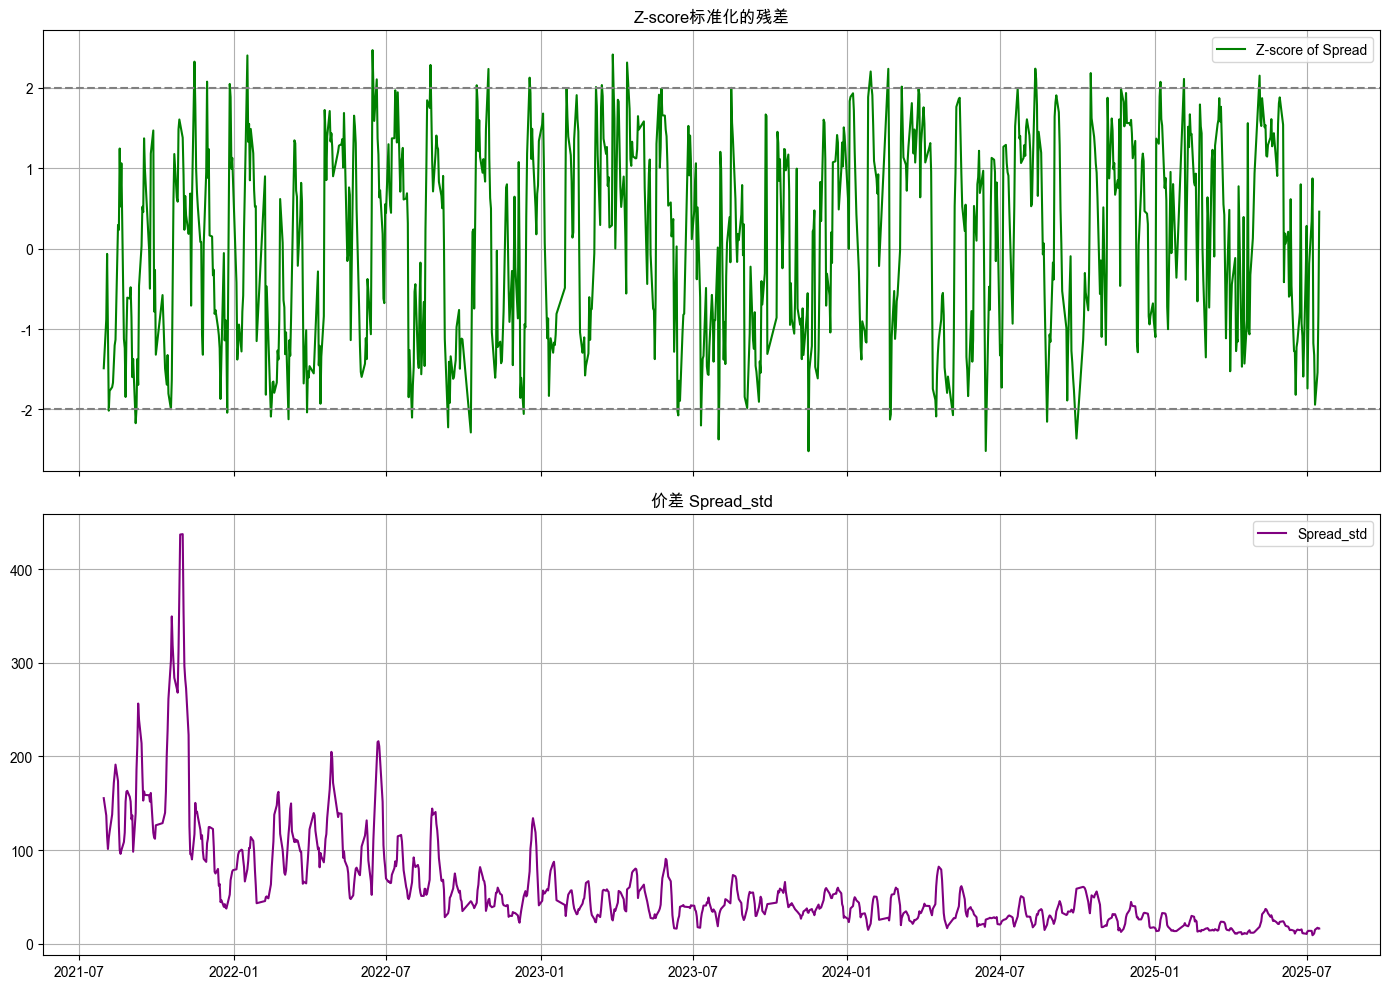

In [7]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'  
# plt.rcParams['font.family'] = 'SimHei'    
plt.rcParams['axes.unicode_minus'] = False

@njit
def kalman_filter_numba(py, px, obs_var, state_var, init_mean, init_var):
    n = len(py)
    betas = np.zeros(n)
    spreads = np.zeros(n)

    state_mean = init_mean
    state_var_ = init_var

    for i in range(n):
        pred_mean = state_mean
        pred_var = state_var_ + state_var
        k_gain = pred_var / (pred_var * px[i]**2 + obs_var)
        state_mean = pred_mean + k_gain * (py[i] - pred_mean * px[i])
        state_var_ = (1 - k_gain * px[i]) * pred_var

        betas[i] = state_mean
        spreads[i] = py[i] - state_mean * px[i]

    return betas, spreads

"""
这里用numba优化了一下，准备看看跑的情况
"""
py = df['铁矿石主连_收盘价'].values.astype(np.float64)
px = df['焦炭主连_收盘价'].values.astype(np.float64)
    
betas, spreads = kalman_filter_numba(
    py, px, OBS_VAR, STATE_VAR, INIT_MEAN, INIT_VAR
)

df['beta_kalman'] = betas
df['spread'] = spreads
df['spread_mean'] = df['spread'].rolling(WIN).mean()
df['spread_std'] = df['spread'].rolling(WIN).std()
df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

#画图看看
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['datetime'], df['zscore'], label='Z-score of Spread', color='green')
axes[0].axhline(2, linestyle='--', color='gray')
axes[0].axhline(-2, linestyle='--', color='gray')
axes[0].set_title("Z-score标准化的残差")
axes[0].legend()
axes[0].grid()

axes[1].plot(df['datetime'], df['spread_std'], label='Spread_std', color='purple')
axes[1].set_title("价差 Spread_std")
axes[1].legend()
axes[1].grid()
    
plt.tight_layout()
plt.show()

In [8]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [9]:
def train_hmm_on_beta_vol_and_plot(
    df,
    beta_col='beta_kalman',
    zscore_col='zscore',
    time_col='datetime',
    window=10,
    n_states=3,
    vol_col='beta_vol',
    state_col='beta_state',
    n_init=10
):
    """
    对beta波动率进行建模
    HMM regime拟合
    """
    df = df.copy()

    ##计算beta_vol，然后log和标准化
    df[vol_col] = df[beta_col].rolling(window=window, min_periods=10).std()
    df[vol_col] = np.log(df[vol_col] + 1e-9)
    df = df.dropna(subset=[vol_col, zscore_col])

    #组合变量
    obs = np.column_stack([df[vol_col].values, df[zscore_col].values])
    scaler = StandardScaler()
    obs_scaled = scaler.fit_transform(obs)
    
    # === Step 2: 多次初始化 HMM，选 log likelihood 最大的 ===
    best_model = None
    best_score = -np.inf
    best_states = None

    for seed in range(n_init):
        model = GaussianHMM(
            n_components=n_states,
            covariance_type="full",
            n_iter=1000,
            random_state=seed,
            init_params='stmc'
        )
        try:
            model.fit(obs_scaled)
            score = model.score(obs_scaled)
            hidden_states = model.predict(obs_scaled)

            if score > best_score:
                best_score = score
                best_model = model
                best_states = hidden_states
        except Exception as e:
            print(f"Seed {seed} failed: {e}")
            continue

    # === Step 3: 状态重新映射（按 beta_vol 均值排序）===
    beta_vol_values = obs_scaled[:, 0]
    means = [beta_vol_values[best_states == i].mean() for i in range(n_states)]
    state_order = np.argsort(means)
    mapping = {original: new for new, original in enumerate(state_order)}
    mapped_states = np.array([mapping[s] for s in best_states])
    df[state_col] = mapped_states
    
    # === Step 4: 画图 ===
    times = df[time_col]
    beta_vol_plot = df[vol_col]
    states = df[state_col]

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(times, beta_vol_plot, label='Beta Volatility (log)', color='black', linewidth=1.2)
    ax1.set_ylabel('Log Beta Volatility (black)')
    ax1.set_xlabel('Time')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.step(times, states, label='HMM State (0=Low, 1=Mid, 2=High)', color='red', linewidth=1.2, where='post', alpha=0.6)
    ax2.set_ylabel('HMM State (red)')
    ax2.set_ylim(-0.1, n_states - 0.9)
    ax2.set_yticks(range(n_states))
    ax2.set_yticklabels(['Low', 'Mid', 'High'])

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=30)
    plt.title('Beta Volatility (log) & Z-score with HMM Regime State')
    fig.tight_layout()
    plt.show()

    return df

def generate_signal_with_hmm_state(
    df,
    z_col='zscore',
    beta_col='beta_kalman',
    state_col='beta_state',
    time_col='datetime',
    close_h=0.3,
    close_l=-0.3,
    stop_spread=1.0,
    start_index=None,
    beta_diff_ratio_thresh=0.01,  # β 相对变化阈值，例如 20%
    state_open_thresholds={0: (2.0, -2.0), 1: (2.0, -2.0), 2: (2.5, -2.5)}
):
    df = df.copy()
    n = len(df)
    df['signal'] = 0
    df['frozen_beta'] = np.nan

    position = 0
    entry_z = None
    entry_time = None
    frozen_beta = None  # 空仓时不保存冻结 beta

    start_i = start_index if start_index is not None else 0

    for i in range(start_i, n):
        z = df.at[df.index[i], z_col]
        t = df.at[df.index[i], time_col]
        beta_now = df.at[df.index[i], beta_col]
        state = df.at[df.index[i], state_col]

        # 根据 HMM 状态取开仓阈值
        if np.isnan(state):
            open_h, open_l = 3.0, -3.0
        else:
            open_h, open_l = state_open_thresholds.get(int(state), (3.0, -3.0))

        if position == 0:
            # 没有持仓，只用动态 beta 参与开仓判断
            if z < open_l:
                position = 1
                entry_z = z
                entry_time = t
                frozen_beta = beta_now if np.isfinite(beta_now) else None
                df.at[df.index[i], 'signal'] = 1
            elif z > open_h:
                position = -1
                entry_z = z
                entry_time = t
                frozen_beta = beta_now if np.isfinite(beta_now) else None
                df.at[df.index[i], 'signal'] = -1
            else:
                df.at[df.index[i], 'signal'] = 0
        else:
            # 持仓时，判断是否平仓：盈利、止损、beta 变化过大
            profit_cond = (close_l < z < close_h)
            stop_cond = ((position == 1 and z < entry_z - stop_spread) or
                         (position == -1 and z > entry_z + stop_spread))

            # 计算相对 beta 偏离，如果无法计算则视为不触发
            if frozen_beta is not None and np.isfinite(beta_now) and np.isfinite(frozen_beta) and abs(frozen_beta) > 1e-12:
                beta_diff_ratio = abs(beta_now - frozen_beta) / abs(frozen_beta)
                beta_ratio_cond = beta_diff_ratio > beta_diff_ratio_thresh
            else:
                beta_ratio_cond = False

            if profit_cond or stop_cond or beta_ratio_cond:
                # 平仓，不更新 frozen_beta，只设为空
                df.at[df.index[i], 'signal'] = 0
                position = 0
                entry_z = None
                entry_time = None
                frozen_beta = None
            else:
                # 继续持仓
                df.at[df.index[i], 'signal'] = position

        # 记录冻结 beta，空仓时为 None
        df.at[df.index[i], 'frozen_beta'] = frozen_beta

    return df

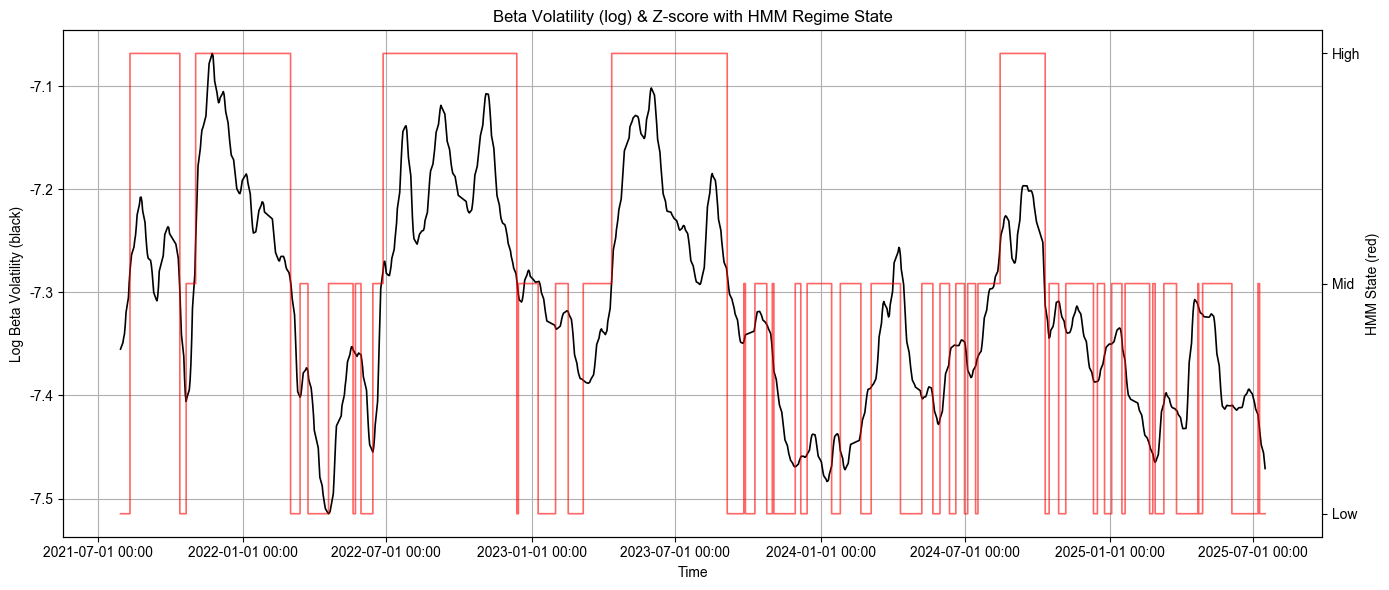

In [10]:
df = train_hmm_on_beta_vol_and_plot(df)

In [11]:
df = generate_signal_with_hmm_state(df)

In [12]:
def calculate_pair_strategy_returns(
    df, 
    price_y='铁矿石主连_收盘价', 
    price_x='焦炭主连_收盘价', 
    beta_col='beta_kalman', 
    signal_col='signal',
    time_col='DateTime',
    freeze_beta=True,
):
    df = df.copy()
    df['position'] = df[signal_col].shift(1).fillna(0)

    if freeze_beta:
        frozen_beta = []
        current_beta = None
        for i in range(len(df)):
            sig = df.iloc[i][signal_col]
            if sig == 1 or sig == -1:
                if current_beta is None:
                    current_beta = df.iloc[i][beta_col]
                frozen_beta.append(current_beta)
            else:
                current_beta = None
                frozen_beta.append(None)
        df['frozen_beta'] = frozen_beta
        df['frozen_beta'] = df['frozen_beta'].fillna(method='ffill')
        beta_used = 'frozen_beta'
    else:
        beta_used = beta_col

    df['ret_y'] = df[price_y].pct_change().fillna(0)
    df['ret_x'] = df[price_x].pct_change().fillna(0)
    df['combo_ret'] = df['position'] * (df['ret_y'] - df[beta_used] * df['ret_x'])

    df['cum_ret'] = (1 + df['combo_ret']).cumprod()
    df['cum_return'] = df['combo_ret'].cumsum()


    return df

def plot_beta_vs_frozen_with_signals(
    df,
    beta_col='beta_kalman',
    frozen_col='frozen_beta',
    signal_col='signal',
    time_col='datetime'):
    df = df.copy()

    entry_long = df[(df[signal_col] == 1) & (df[signal_col].shift(1) == 0)]
    entry_short = df[(df[signal_col] == -1) & (df[signal_col].shift(1) == 0)]

    plt.figure(figsize=(14, 6))
    
    plt.plot(df[time_col], df[beta_col], label='Kalman β (Dynamic)', color='blue', linewidth=1.5)
    plt.plot(df[time_col], df[frozen_col], label='Frozen β (Trading)', color='orange', linestyle='--', linewidth=1.5)

    plt.scatter(entry_long[time_col], entry_long[frozen_col], marker='^', color='green', label='Long Entry', zorder=5)
    plt.scatter(entry_short[time_col], entry_short[frozen_col], marker='v', color='red', label='Short Entry', zorder=5)

    plt.title("动态 β vs 冻结 β 与交易信号")
    plt.xlabel("时间")
    plt.ylabel("β")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_position_and_return_with_hmm(
    df,
    time_col='datetime',
    position_col='position',
    cumret_col='cum_ret',
    state_col='beta_state'
):
    """
    持仓与收益图，带 HMM 状态背景色
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # 设置颜色映射（可根据实际调整）
    state_colors = {
        0: 'lightgreen',   # Low Vol
        1: 'lightyellow',  # Mid Vol
        2: 'lightcoral'    # High Vol
    }

    for ax in axes:
        # 遍历状态变化区间，绘制背景色
        last_state = None
        start_time = None

        for i in range(len(df)):
            state = df.iloc[i][state_col]
            time = df.iloc[i][time_col]

            if state != last_state:
                if last_state is not None and start_time is not None:
                    ax.axvspan(start_time, time, color=state_colors.get(last_state, 'lightgray'), alpha=0.2)
                start_time = time
                last_state = state

        # 绘制最后一段背景
        if last_state is not None and start_time is not None:
            ax.axvspan(start_time, df[time_col].iloc[-1], color=state_colors.get(last_state, 'lightgray'), alpha=0.2)

    # 第一张图：仓位图
    axes[0].plot(df[time_col], df[position_col], label='Position', color='orange')
    axes[0].set_title("持仓信号")
    axes[0].set_ylim([-1.1, 1.1])
    axes[0].legend()
    axes[0].grid()

    # 第二张图：收益图
    axes[1].plot(df[time_col], df[cumret_col], label='Cumulative Return', color='green')
    axes[1].set_title("策略累计收益")
    axes[1].legend()
    axes[1].grid()

    axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [13]:
df = calculate_pair_strategy_returns(df)

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_15326/4105784772.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['frozen_beta'] = df['frozen_beta'].fillna(method='ffill')


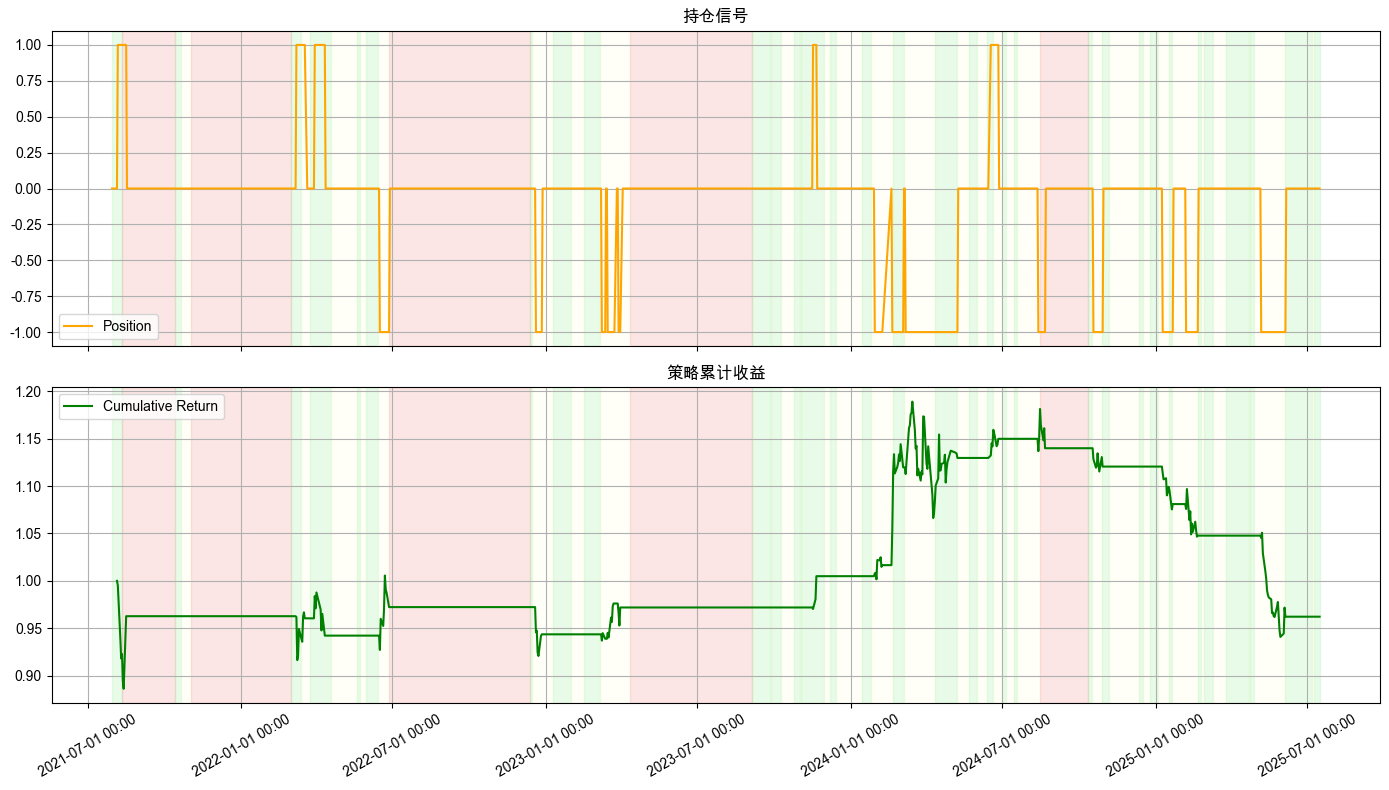

In [14]:
plot_position_and_return_with_hmm(df)

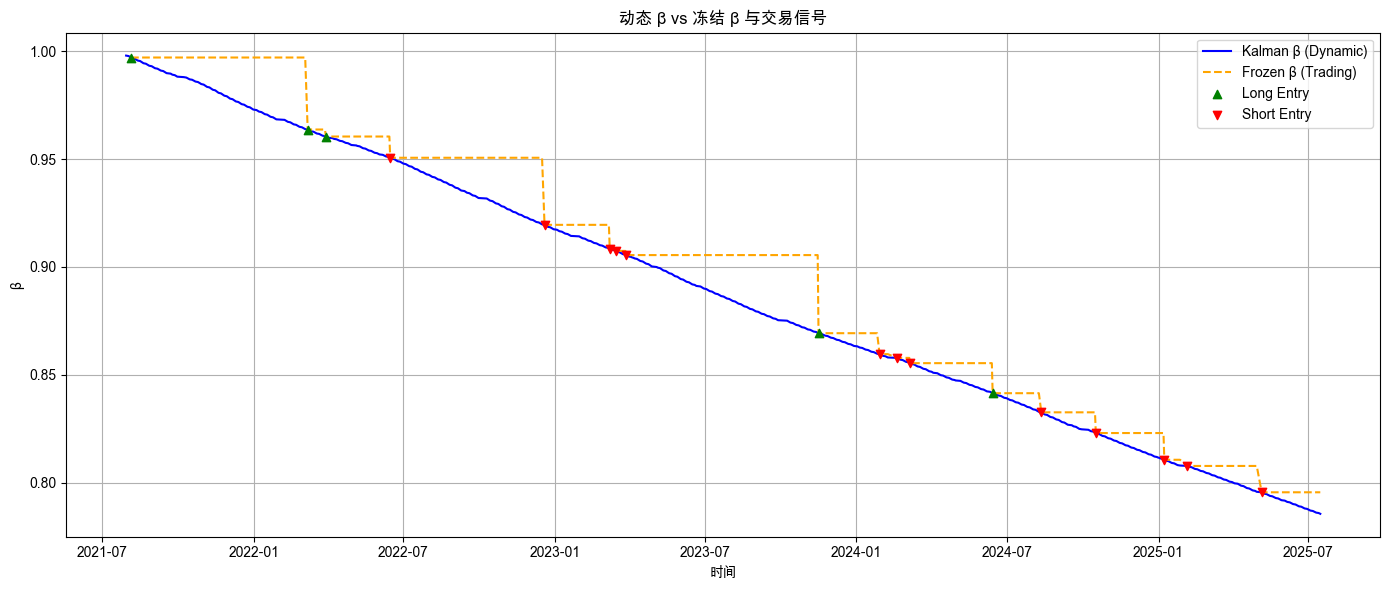

In [15]:
plot_beta_vs_frozen_with_signals(df)